In [14]:
import cv2
import numpy as np

image_path = "Pistachio_Image_Dataset/Kirmizi_Pistachio/kirmizi (1).jpg"

def load_image(image_path):

    """Carga una imagen y la prepara para extracción de características"""
    # Cargar imagen
    img = cv2.imread(str(image_path))

    # Convertir a RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Convertir a escala de grises
    img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

    return img_rgb, img_gray

img_rgb, img_gray = load_image(image_path)

In [15]:
print(img_rgb.shape)
print(img_gray.shape)

(600, 600, 3)
(600, 600)


In [16]:
def segment_pistachio(img_gray):
    """Segmenta el pistacho del fondo negro"""
    # Threshold para separar objeto del fondo negro
    _, binary = cv2.threshold(img_gray,50,255,cv2.THRESH_BINARY)

    # Limpiar ruido
    kernel = np.ones((3,3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    return binary

In [21]:
binary = segment_pistachio(img_gray)
binary

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(600, 600), dtype=uint8)

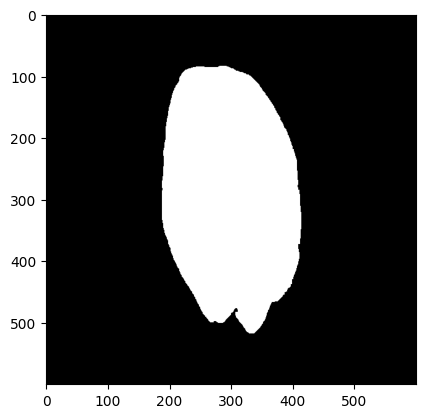

In [22]:
import matplotlib.pyplot as plt

plt.imshow(binary, cmap= 'gray')

In [33]:
def extract_area(binary_img):
    """Extrae el área del objeto en píxeles"""

    return np.sum(binary_img == 255)

In [24]:
area = extract_area(binary)
area

np.int64(76296)

In [34]:
def extract_perimeter(binary_img):
    """Extrae el perímetro del objeto"""
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Tomar el contorno más grande (el pistacho principal)
    largest_contour = max(contours, key = cv2.contourArea)

    perimeter = cv2.arcLength(largest_contour, True)
    return perimeter

In [26]:
perimeter = extract_area(binary)
perimeter

1191.1757484674454

In [27]:
def extract_axes(binary_img):
    """Extrae major axis y minor axis usando elipse ajustada"""
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Ajustar elipse al contorno
    ellipse = cv2.fitEllipse(largest_contour)
    
    # Extraer ejes (width, height)
    (center, (width, height), angle) = ellipse
    
    major_axis = max(width, height)
    minor_axis = min(width, height)
    
    return major_axis, minor_axis

In [28]:
major_axis, minor_axis = extract_axes(binary)
print(f"MAJOR_AXIS: {major_axis:.2f}")
print(f"MINOR_AXIS: {minor_axis:.2f}")

MAJOR_AXIS: 428.67
MINOR_AXIS: 227.05


In [29]:
def extract_eccentricity(major_axis, minor_axis):
    """Calcula la excentricidad de la elipse"""
    # Evitar división por cero
    if major_axis == 0:
        return 0
    
    eccentricity = np.sqrt(1 - (minor_axis/major_axis)**2)
    return eccentricity

In [30]:
eccentricity = extract_eccentricity(major_axis, minor_axis)
print(f"ECCENTRICITY: {eccentricity:.4f}")

ECCENTRICITY: 0.8482


In [31]:
def extract_solidity_convex_area(binary_img):
    """Extrae solidity y convex area"""
    contours, _ = cv2.findContours(binary_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Área convexa
    hull = cv2.convexHull(largest_contour)
    convex_area = cv2.contourArea(hull)
    
    # Solidez = área_objeto / área_convexa
    object_area = cv2.contourArea(largest_contour)
    solidity = object_area / convex_area if convex_area > 0 else 0
    
    return solidity, convex_area

In [32]:
solidity, convex_area = extract_solidity_convex_area(binary)
print(f"SOLIDITY: {solidity:.4f}")
print(f"CONVEX_AREA: {convex_area:.0f}")

SOLIDITY: 0.9791
CONVEX_AREA: 77383


In [35]:
def extract_all_features(img_rgb, binary_img):
    """Extrae todas las 16 características morfológicas y de forma"""
    # Ya implementadas
    area = extract_area(binary_img)
    perimeter = extract_perimeter(binary_img)
    major_axis, minor_axis = extract_axes(binary_img)
    eccentricity = extract_eccentricity(major_axis, minor_axis)
    solidity, convex_area = extract_solidity_convex_area(binary_img)
    
    # Calculamos las que faltan
    eqdiasq = np.sqrt(4 * area / np.pi)  # Diámetro equivalente
    extent = area / (img_rgb.shape[0] * img_rgb.shape[1])  # Proporción del área total
    aspect_ratio = major_axis / minor_axis if minor_axis != 0 else 0
    roundness = (4 * np.pi * area) / (perimeter**2) if perimeter != 0 else 0
    compactness = (perimeter**2) / area if area != 0 else 0
    
    # Shape factors (fórmulas estándar)
    shapefactor_1 = (4 * np.pi * area) / (perimeter**2) if perimeter != 0 else 0
    shapefactor_2 = (np.pi * (major_axis/2)**2) / area if area != 0 else 0  
    shapefactor_3 = major_axis / area if area != 0 else 0
    shapefactor_4 = area / (major_axis**2) if major_axis != 0 else 0
    
    return [area, perimeter, major_axis, minor_axis, eccentricity, eqdiasq, 
            solidity, convex_area, extent, aspect_ratio, roundness, compactness,
            shapefactor_1, shapefactor_2, shapefactor_3, shapefactor_4]

In [36]:
extract_all_features(img_rgb, binary)

[np.int64(76296),
 1191.1757484674454,
 428.6725769042969,
 227.04904174804688,
 np.float64(0.8482124877715099),
 np.float64(311.67785340815277),
 0.9791427057622475,
 77383.0,
 np.float64(0.21193333333333333),
 1.8880175560484804,
 np.float64(0.6757093802306188),
 np.float64(18.597300824905354),
 np.float64(0.6757093802306188),
 np.float64(1.891644469642359),
 np.float64(0.0056185458858170395),
 np.float64(0.4151933283456475)]

In [37]:
import csv
import os

def create_dataset_csv(base_path, output_csv="pistachio_features.csv"):
    """Crea dataset escribiendo directamente a CSV con csv.writer"""
    
    # Nombres de columnas
    feature_names = ['AREA', 'PERIMETER', 'MAJOR_AXIS', 'MINOR_AXIS', 'ECCENTRICITY', 
                    'EQDIASQ', 'SOLIDITY', 'CONVEX_AREA', 'EXTENT', 'ASPECT_RATIO', 
                    'ROUNDNESS', 'COMPACTNESS', 'SHAPEFACTOR_1', 'SHAPEFACTOR_2', 
                    'SHAPEFACTOR_3', 'SHAPEFACTOR_4', 'CLASS']
    
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        
        # Escribir header
        writer.writerow(feature_names)
        
        total_processed = 0
        
        # Procesar Kirmizi
        kirmizi_path = os.path.join(base_path, "Kirmizi_Pistachio")
        for filename in os.listdir(kirmizi_path):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(kirmizi_path, filename)
                try:
                    img_rgb, img_gray = load_image(img_path)
                    binary = segment_pistachio(img_gray)
                    features = extract_all_features(img_rgb, binary)
                    features.append('Kirmizi_Pistachio')
                    
                    writer.writerow(features)
                    total_processed += 1
                    
                    if total_processed % 100 == 0:
                        print(f"Procesadas: {total_processed}")
                        
                except Exception as e:
                    print(f"Error con {filename}: {e}")
        
        # Procesar Siirt
        siirt_path = os.path.join(base_path, "Siirt_Pistachio") 
        for filename in os.listdir(siirt_path):
            if filename.endswith(('.jpg', '.png')):
                img_path = os.path.join(siirt_path, filename)
                try:
                    img_rgb, img_gray = load_image(img_path)
                    binary = segment_pistachio(img_gray)
                    features = extract_all_features(img_rgb, binary)
                    features.append('Siirt_Pistachio')
                    
                    writer.writerow(features)
                    total_processed += 1
                    
                    if total_processed % 100 == 0:
                        print(f"Procesadas: {total_processed}")
                        
                except Exception as e:
                    print(f"Error con {filename}: {e}")
    
    print(f"¡Completado! Total procesadas: {total_processed}")
    return output_csv


csv_file = create_dataset_csv("Pistachio_Image_Dataset")
print(f"Dataset guardado en: {csv_file}")

Procesadas: 100
Procesadas: 200
Procesadas: 300
Procesadas: 400
Procesadas: 500
Procesadas: 600
Procesadas: 700
Procesadas: 800
Procesadas: 900
Procesadas: 1000
Procesadas: 1100
Procesadas: 1200
Procesadas: 1300
Procesadas: 1400
Procesadas: 1500
Procesadas: 1600
Procesadas: 1700
Procesadas: 1800
Procesadas: 1900
Procesadas: 2000
Procesadas: 2100
¡Completado! Total procesadas: 2148
Dataset guardado en: pistachio_features.csv
